<p align="center">
  <a>
    <img src="./figures/logo-hi-paris-retina.png" alt="Logo" width="280" height="180">
  </a>

  <h3 align="center">Data Science Bootcamp</h3>
</p>

### Train / Val / Test Split
The **train-validation-test** split is a technique for training and evaluating the performance of a machine learning algorithm.

The **procedure** involves taking a dataset and dividing it into three subsets:
- The **train** subset is used to fit the model and is referred to as the training dataset. You should not evaluate the performance of the model on this train set,
- The **validation** subset is used to tune (select the best) hyperparameters of an algorithm. For example the *max_depth* for a regression tree. It is used to compare different versions of the model with different hyperparameters, but not to evaluate it.
- The **test** subset is not used to train the model; it is only used at the end to evaluate the performances of the model. For a purist, once you 'opened' the test set, you should not modify the model anymore.  

Test set cannot be used for validation as it could lead to overifitting while selecting amongst different models with different hyperparameters. It should only be used for evaluation and not for tuning.

**Strategy**
   - Define a test set, and separate the remaining between train and validation.
   - Generally they represent respectively 70% | 15% | 15% of the initial dataset.

<img src="./figures/train_test_1.png" width=700 height=400 />

However there is a specificity to our problem as we are dealing with timeseries. By shuffling the data and randomly selecting examples to build our different sets we would be facing a problem of leaking future information with past information :  
If we randomly selected data points for our training set and test set we would have fires in the train set that would be of later dates than some in the test set. This would mean that the model learnt from future informations and thus is "cheating" since it already knows some of what happens next (e.g. there was a serie of fire afterwards). This is called leaking and we want to avoid it.

As a consequence, we will be using a different type of split made for time series : 

<img src="./figures/TimeSeriesSplit.png" width=700 height=400 />

The lines 0 to 3 are our different split. The data is organized in chronological order. We first use a portion of the data to train, and then test on the following portion of data (line 0). We then repeat this process by adding the previous testing set to our training set and using the following portion as our testing set. We then repeat this operation until we have covered the whole dataset.  
Some small adjusment which can be made is to add a "gap" between the training and testing set. Since we are dealing with time series, following samples can be highly dependent (e.g. we have two consecutive data points in the same part of the country, the first fire having created the second). If we split between this two point we would have the illusion of testing our model on independent data while we would have been lucky on this example. In order to prevent this effect of dependence we add a gap of discarded data between the training set and testing set. 

<img src="./figures/TimeSeriesGap.png" width=700 height=400 />

### Features / Target Split
It is a rather practical approach because generally the algorithms of machine learning ask for the features on the one hand and the target on the other hand.

<img src="./figures/split_columns.png" width=700 height=500 />





## [Bias / Variance Trade-off](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

<img src="./figures/Overfitting.PNG" width=600 height=200 />

$\textbf{UNDERFITTING :}$ The model is too simple to capture the relationships between the data

*Solutions*:
- Introduce more features
- Increase model complexity

$\textbf{OVERFITTING :}$ The model is too complex and sticks too closely to the training data

*Solutions*:

- Decrease model complexity
- Include more data
- Use regularization


## Random Forests

The main problem with decision trees is their large variance: a tiny error at the top of the tree is propagated all the way down the tree and it gets worse quickly. To stabilize the tree's predictions, we prefer to generate a set of trees, a forest and this algorithm is called *Random Forest*.

To create a random forest with B trees, we proceed as follows:

- For i ranging from 1 to B:
  - We draw randomly with replacement a sub-sample of the data size $ n <n _ {\ text {train}} $
  - We randomly draw a subsample of features of size m with in general $ m \leq \sqrt {p} $
  - On this new dataset composed of n examples and m features, we train a decision tree of fixed max depth
- We thus obtain $ B $ decision trees. If we denote by $ f1, ..., fB $ the prediction functions of each tree, then in regression, the decision function of the forest $ f_ {RF} $ will be:

$f_{RF} (x) = \frac{1}{B} \sum_{i = 1, ..., B} f_i (x)$

<img src="./figures/RF.png" width=900 height=500 />

### The mains parameters

- *n_estimators* : number of trees in the foreset

- *max_features* : max number of features considered for splitting a node

- *max_depth* : max number of levels in each decision tree

Objective of this lab
======

Experiment with multiple models and hyperparameters and select the one with the best score.
Use Cross-validation (among other methods) to avoid overfitting.
Use explainability to understand and present the model's predictions.

We will use the [sklearn package](https://scikit-learn.org/stable/) for models and various metrics. You also have the possibility to use the [XGBoost](https://xgboost.readthedocs.io/en/stable/) model if you feel confident with it, it has the nice property of allowing to use the same methods as sklearn models. 

### Dependencies with previous Labs

This lab uses one dataset from a previous Lab:
- a dataset ready to use for an ML model `./data/3_input_model/input_model.csv`

You can either:
- [preferred option] start over from the work that you produced
- or take pre-processed datasets located in `./data/9_helper_datasets`. In that case:
    - `./data/9_helper_datasets/input_model.csv` should be **copied** (not deleted) to `./data/3_input_model/input_model.csv`

#### Libraries

In [1]:
!pip install xgboost
!pip install git+https://github.com/slundberg/shap.git


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/slundberg/shap.git to /tmp/pip-req-build-8fwr4g4k
  Running command git clone --filter=blob:none --quiet https://github.com/slundberg/shap.git /tmp/pip-req-build-8fwr4g4k
  Resolved https://github.com/slundberg/shap.git to commit 45b85c1837283fdaeed7440ec6365a886af4a333
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

# Typing and error catching
from functools import partial
from typing import Tuple, Any, Union
from shap.utils._exceptions import InvalidModelError
MODEL_TYPE = Union[LogisticRegression, RandomForestClassifier, XGBClassifier]

#### Step 1. Get Train, val, test, and pred datasets

In [3]:
# inputs
data = pd.read_csv("./data/3_input_model/input_model.csv", parse_dates=["DISCOVERY_DATE"])
min_year_pred = "2015-01-01"
target_col = "FIRE"
ratio = 0.75

# find max number of occurrence per day
max_occ_day = data.groupby("DISCOVERY_DATE").agg({"STATE":"count"}).max().values[0]

# split train and prediction datasets
X_pred = data[data["DISCOVERY_DATE"] >= min_year_pred].set_index(["DISCOVERY_DATE", "STATE"]).copy()
X_pred.drop(columns=["FIRE"], inplace=True) # get features for predictions
data = data[data["DISCOVERY_DATE"] < min_year_pred].copy() # get train data (features and target values)
data[target_col] = data[target_col].astype("int")

In [4]:
def features_target_split(df:pd.DataFrame, col:str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Split features and target values. 
    It is meant to help you in the next function, you can skip if you feel like it

    Input:
    data (pd.DataFrame) : input DataFrame with features and target values
    col (str) : name of the target value column

    Output:
    X (pd.DataFrame): DataFrame with features
    y (pd.DataFrame): DataFrame with target values
    '''
    #################
    # TO BE FILLED  #
    ################# 
    X=df.drop(col,axis=1)
    y=df[col].to_frame()
    
    return X, y

In [5]:
# Test features_target_split
target_col = "FIRE"
X_train, y_train = features_target_split(data, target_col)

In [6]:
def train_test_split(df:pd.DataFrame, col:str, ratio: float = 0.75) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Split inputs into 2 sets of data: training (train) and test (test).
    Each set of data is splitted into features (X) and target values (y).
    Be careful not to split with shuffling as we need to keep the chronological order
    

    Input:
    data (pd.DataFrame) : input DataFrame with features and target values
    col (str) : name of the target value column
    ratio (float) : split ratio, between 0 and 1, to split train and validation data

    Output:
    X_train (pd.DataFrame): DataFrame for training with features
    y_train (pd.DataFrame): DataFrame for training with target values
    X_test (pd.DataFrame): DataFrame for testing with features
    y_test (pd.DataFrame): DataFrame for testing with target values
    '''
    # spint train and test sets
    df = df.sort_values(by=["DISCOVERY_DATE"])
    index_ratio = int(ratio * df.shape[0]) # find the row number where we want to split
    split_date = df.iloc[index_ratio, df.columns.get_loc("DISCOVERY_DATE")] # find the corresponding data
    data_train = df[df["DISCOVERY_DATE"] < split_date].set_index(["DISCOVERY_DATE", "STATE"]).copy()
    data_test = df[df["DISCOVERY_DATE"] >= split_date].set_index(["DISCOVERY_DATE", "STATE"]).copy()
    
    # split between features and target values
    X_train, y_train = features_target_split(data_train, col)
    X_test, y_test = features_target_split(data_test, col)
    
    return X_train, y_train, X_test, y_test

In [7]:
# split train, val and test sets
X_train_val, y_train_val, X_test, y_test = train_test_split(data, target_col, ratio)

#### Step 2. Use Train data for parameters tuning

In [8]:
def model_fit_predict(model:MODEL_TYPE, X_train:pd.DataFrame, y_train:pd.DataFrame, X_val:pd.DataFrame) -> Tuple[pd.DataFrame, Any]:
    '''
    Create a model, fit it on X_train and y_train, and predict the target values from X_val

    Input:
    model (MODEL_TYPE) : The model to fit and to then use for predictions on the validation set
    X_train (pd.DataFrame) : input DataFrame with features for training
    y_train (pd.DataFrame) : input DataFrame with target values for training
    X_val (pd.DataFrame) : input DataFrame with features for validation

    Output:
    y_pre (pd.DataFrame): predictions based on the features from X_val
    model : trained model
    '''
    #################
    # TO BE FILLED  #
    #################
    trained_model=model.fit(X_train,y_train.values.ravel())
    y_pre=model.predict(X_val)
    
    
    return y_pre,trained_model
    

In [9]:
# Test model_fit_predict

random_forest = RandomForestClassifier()
y_pre, trained_model = model_fit_predict(random_forest, X_train_val, y_train_val, X_test)

In [10]:
def scoring(y_true:pd.DataFrame, y_pre:pd.DataFrame) -> dict:
    '''
    Return a dictionary with keys corresponding to score name and values corresponding to the associated score

    Input:
    y_true (pd.DataFrame) : input DataFrame with true labels
    y_pre (pd.DataFrame) : input DataFrame with predicted labels

    Output:
    (dict): output dictionary with scores
    '''
    return {
        "f1-micro": f1_score(y_true, y_pre, average="micro"),
        "f1-macro": f1_score(y_true, y_pre, average="macro"),
        "f1-weighted": f1_score(y_true, y_pre, average="weighted"),
        "accuracy": accuracy_score(y_true, y_pre)
    }

def print_scoring(scores:dict) -> None:
    '''
    Print scores from a dictionary

    Input:
    scores (dict) : dictionary with keys corresponding to score name and values corresponding to the associated score

    Output:
    None
    '''
    for name, score in scores.items():
        print(f"{name}: {score}")

In [11]:
# Test scoring
scores = scoring(y_test, y_pre)
print_scoring(scores)

f1-micro: 0.800126103404792
f1-macro: 0.7800494214079221
f1-weighted: 0.7992252714125845
accuracy: 0.800126103404792


In [12]:
def plot_confusion_matrix(y_test:pd.DataFrame, y_pre:pd.DataFrame, nb_values:int) -> None:
    '''
    Plot the confusion matrix based on the provided true and predicted labels

    Input:
    y_true (pd.DataFrame) : input DataFrame with true labels
    y_pre (pd.DataFrame) : input DataFrame with predicted labels
    nb_values (int) : nb of target values

    Output:
    None
    '''
    s = sns.heatmap(
        confusion_matrix(y_test, y_pre),
        xticklabels=range(nb_values),
        yticklabels=range(nb_values),
        annot=True,
        cmap='Blues',
        fmt='g',
        cbar=False
    )
    s.set(xlabel='True label', ylabel='Predicted label')
    plt.show()

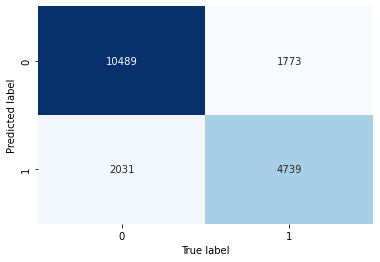

In [13]:
# Test confusion matrix
plot_confusion_matrix(y_test, y_pre, 2)

In [14]:
def rf_features_importance(model: MODEL_TYPE, cols:list) -> None:
    '''
    Plot feature_importance from a random forest model

    Input:
    model (MODEL_TYPE) : Model for which to compute the feature importance
    cols (list) : input DataFrame with true labels

    Output:
    None
    '''
    # get feature importance from model
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=cols).sort_values(ascending=False)[:10]
    # plot results
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances")
    fig.tight_layout()
 

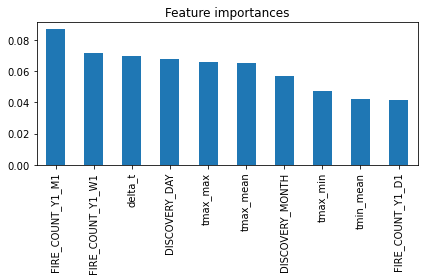

In [15]:
# Test random forest feature importance
rf_features_importance(random_forest, cols=X_train_val.columns)

In [16]:
def cross_validation_score(model: MODEL_TYPE, X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, gap:int) -> Tuple[MODEL_TYPE, dict]:
    '''
    Cross validation for time series, with 5 splits.

    Input:
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    gap (int) : number of entries between 2 sets during the cross-validation

    Output:
    model: trained model
    '''
    # cross-validation for time series
    tscv = TimeSeriesSplit(n_splits=3, gap=gap)
    y_pre, y_val, trained_model = None, None, None
    scores_history = []
    i = 0
    for train_index, val_index in tscv.split(X_train_val):
        i += 1 # increase iteration
        # get datasets (train and val)
        train_index = list(train_index)
        val_index = list(val_index)
        X_train, X_val = X_train_val.iloc[train_index, :], X_train_val.iloc[val_index, :]  
        y_train, y_val = y_train_val.iloc[train_index, :], y_train_val.iloc[val_index, :]
        # fit model and predict y_val
        y_pre, trained_model = model_fit_predict(model, X_train, y_train, X_val)
        # scoring
        scores = scoring(y_val, y_pre)
        scores_history.append(scores)
        print("")
        print(f"Step {i}")
        print_scoring(scores)

    return trained_model, scores

In [17]:
logistic_regression = LogisticRegression()
logistic_regression, logistic_scores = cross_validation_score(logistic_regression, X_train_val, y_train_val, gap = max_occ_day)


Step 1
f1-micro: 0.4992623814541623
f1-macro: 0.48365331770050923
f1-weighted: 0.49848035159337317
accuracy: 0.4992623814541623

Step 2
f1-micro: 0.6211450649806814
f1-macro: 0.3831520561598128
f1-weighted: 0.4759860176417372
accuracy: 0.6211450649806814

Step 3
f1-micro: 0.7291183702142606
f1-macro: 0.6738240634113172
f1-weighted: 0.7120989316419164
accuracy: 0.7291183702142606


In [18]:
# train model on X_train_val and y_train_val
random_forest = RandomForestClassifier()
random_forest, random_forest_scores = cross_validation_score(random_forest, X_train_val, y_train_val, gap = max_occ_day)


Step 1
f1-micro: 0.7557428872497367
f1-macro: 0.7457654777713442
f1-weighted: 0.754083523758472
accuracy: 0.7557428872497366

Step 2
f1-micro: 0.7898840885142255
f1-macro: 0.7789931592132608
f1-weighted: 0.7908801260357378
accuracy: 0.7898840885142255

Step 3
f1-micro: 0.7807516684229013
f1-macro: 0.7696727818297737
f1-weighted: 0.7840696565601768
accuracy: 0.7807516684229013


In [19]:
xgb_model = XGBClassifier()
xgb_model, xgb_scores = cross_validation_score(xgb_model, X_train_val, y_train_val, gap = max_occ_day)


Step 1
f1-micro: 0.7570776255707763
f1-macro: 0.7451872247380158
f1-weighted: 0.7542780645291768
accuracy: 0.7570776255707763

Step 2
f1-micro: 0.7950825430277485
f1-macro: 0.7846439966743161
f1-weighted: 0.7961317268507643
accuracy: 0.7950825430277485

Step 3
f1-micro: 0.7837021426062522
f1-macro: 0.7714648527209319
f1-weighted: 0.7865367061103504
accuracy: 0.7837021426062522


# Hyperparameters tuning

In [20]:
random_forest_params = {"n_estimators":[100,200], 'min_samples_split': [2,5,10]}

In [21]:
best_random_forest = GridSearchCV(random_forest, random_forest_params, scoring=None, n_jobs=None, refit=True, cv=TimeSeriesSplit(n_splits=3, gap=max_occ_day))

In [22]:
#from sklearn.model_selection import GridSearchCV
#cv = GridSearchCV(random_forest,parameters,cv=5)
#cv.fit(X_train_val,y_train_val.values.ravel())

In [23]:
#def display(results):
 #   print(f'Best parameters are: {results.best_params_}')
  #  print("\n")
   # mean_score = results.cv_results_['mean_test_score']
    #std_score = results.cv_results_['std_test_score']
    #params = results.cv_results_['params']
    #for mean,std,params in zip(mean_score,std_score,params):
     #   print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [24]:
#display(cv)

In [25]:
xgb_params = {
        'min_child_weight': [5, 10],
        'gamma': [1, 2],
        }

In [26]:
best_xgb = GridSearchCV(xgb_model, xgb_params, scoring=None, n_jobs=None, refit=True, cv=TimeSeriesSplit(n_splits=3, gap=max_occ_day))

#### Step 3. Test the model on the Test set, and refit the model on the entire data set

In [27]:
# to be done only few times (risk of overfitting)
def score_test_set(model:Any, X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame) -> None:
    '''
    Fit the model on the entire X_train_val and y_train_val data, and predict values for the test set

    Input:
    model (MODEL_TYPE) : model used for training the the previous section of the notebook
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    X_test (pd.DataFrame) : input DataFrame with features for testing
    y_test (pd.DataFrame) : input DataFrame with target values for testing

    Output:
    None
    '''
    # fit model on entire X_train_val, y_train_val datasets
    model.fit(X_train_val, y_train_val.values.ravel())
    y_pred = model.predict(X_test)
    # score test set
    scores = scoring(y_test, y_pred)
    print_scoring(scores)
    # plot the last confusion matrix
    plot_confusion_matrix(y_test, y_pred, nb_values=2)
    # plot features importance
    cols = X_train_val.columns # get columns names
    if 'feature_importances_' in dir(model):
        rf_features_importance(model, cols) # plot feature importance

f1-micro: 0.8035939470365699
f1-macro: 0.784300488487353
f1-weighted: 0.8029160321191694
accuracy: 0.8035939470365699


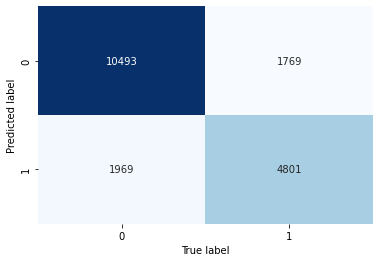

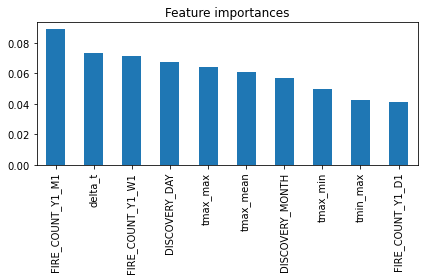

In [28]:
score_test_set(random_forest, X_train_val, y_train_val, X_test, y_test)

LogisticRegression
f1-micro: 0.7346574190836486
f1-macro: 0.6592738367502519
f1-weighted: 0.7055212266268175
accuracy: 0.7346574190836486


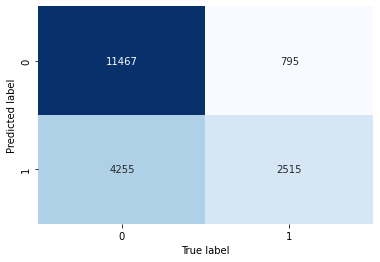

XGBClassifier
f1-micro: 0.8086906263135771
f1-macro: 0.790832713671588
f1-weighted: 0.8084690481851294
accuracy: 0.8086906263135771


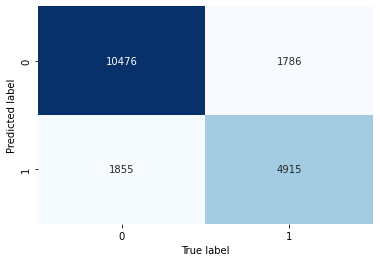

RandomForestClassifier
f1-micro: 0.8033837746952501
f1-macro: 0.783724895182816
f1-weighted: 0.8025409576230894
accuracy: 0.8033837746952501


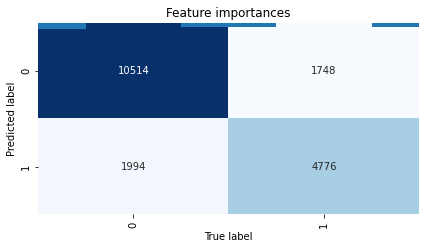

GridSearchCV
f1-micro: 0.8060634720470786
f1-macro: 0.7869168798705277
f1-weighted: 0.8053486211910567
accuracy: 0.8060634720470786


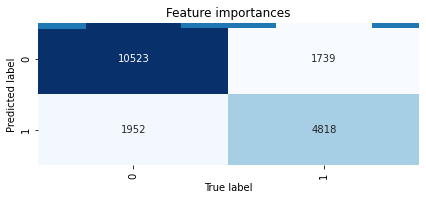

GridSearchCV
f1-micro: 0.8081651954602774
f1-macro: 0.7899467286675275
f1-weighted: 0.80779790076847
accuracy: 0.8081651954602774


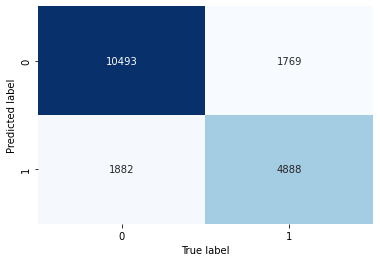

In [29]:
for model in (logistic_regression, xgb_model, random_forest, best_random_forest, best_xgb):
    print(model.__repr__().split('(')[0])
    score_test_set(model, X_train_val, y_train_val, X_test, y_test)

#### Step 4. Create the submission file

In [ ]:
def fit_model_all_data(model: MODEL_TYPE, X_train_val:pd.DataFrame, y_train_val:pd.DataFrame, X_test:pd.DataFrame, y_test:pd.DataFrame):
    '''
    Fit the model on the entire X_train_val and X_test features

    Input:
    model : model used for training the the previous section of the notebook
    X_train_val (pd.DataFrame) : input DataFrame with features for training
    y_train_val (pd.DataFrame) : input DataFrame with target values for training
    X_test (pd.DataFrame) : input DataFrame with features for testing
    y_test (pd.DataFrame) : input DataFrame with target values for testing

    Output:
    model : model trained on all available data
    '''
    # fit model on entire X_train_val, y_train_val datasets
    X = pd.concat([X_train_val, X_test])
    y = pd.concat([y_train_val, y_test])
    model.fit(X, y.values.ravel())
    return model
    

def save_predictions(X_pred:pd.DataFrame, model:MODEL_TYPE, filename:str) -> None:
    '''
    Save predictions (year 2015) to csv format, based on a provided pre-trained model, and features for predictions X_pred

    Input:
    X_pred (pd.DataFrame) : input DataFrame with features for predictions
    model (MODEL_TYPE) : input pre-trained model, which has a predict method
    filename (str) : Name of the file for submission

    Output:
    None
    '''
    # predict target values
    y_pred = model.predict(X_pred)
    # create a DataFrame with results
    submission = pd.DataFrame(
        data=y_pred,
        index=X_pred.index,
        columns=["CAUSE_CODE"]
    ).reset_index()
    # save to csv
    submission.to_csv(f"./data/4_predictions/{filename}.csv", index=False)

def save_model(model: MODEL_TYPE, file_name:str) -> None:
    os.makedirs('./models', exist_ok=True)
    dump(model, f'./models/{file_name}.joblib') 

def load_model(file_name:str) -> MODEL_TYPE:
    return load(f'./models/{file_name}.joblib') 

In [ ]:
# save predictions to csv
filename = "submission_group_X"
model = fit_model_all_data(model, X_train_val, y_train_val, X_test, y_test)


In [ ]:
save_predictions(X_pred, model, filename)

In [ ]:
# Save model if necessary, for example if you want to close this notebook and continue fine-tuning later
save_model(model, file_name="model_test")

In [ ]:
del model

In [ ]:
# Load model if necessary for further experiments
model = load_model('model_test')

# Explainability

  
Now that we have a working model, we can try to understand how its predictions are made. Beyond feature importance we can study [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html). They allow us to see the importance of each feature as well as how each feature impacts the predictions towards a prediction or the other depending on the feature value.

## Shapley values

In [30]:
def plot_shapley_values(model:MODEL_TYPE)->None:
    '''
    Plot the shapley graph of the given model.
    ##########################################################################
    WARNING : Do not use it on random forest as it takes a huge amout of time.
    ##########################################################################
    Input:
    model (MODEL_TYPE) : Model for which to explain the predictions

    Output:
    None
    '''
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    except (InvalidModelError, TypeError) as error:
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
        

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


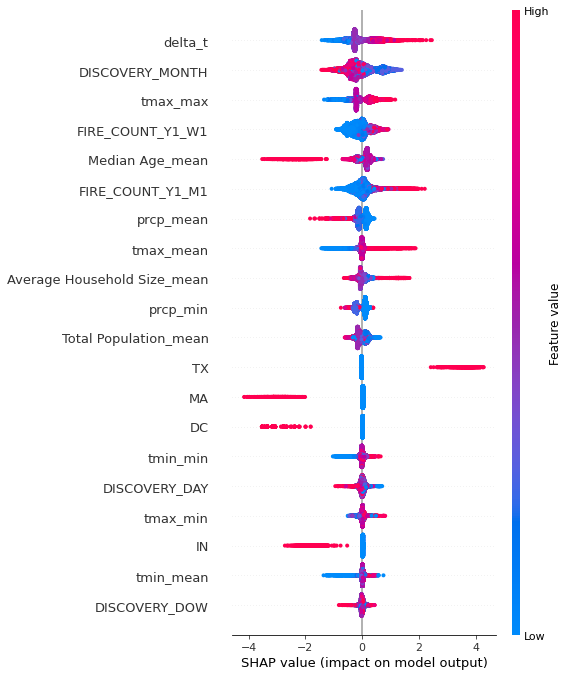

In [31]:
plot_shapley_values(xgb_model)

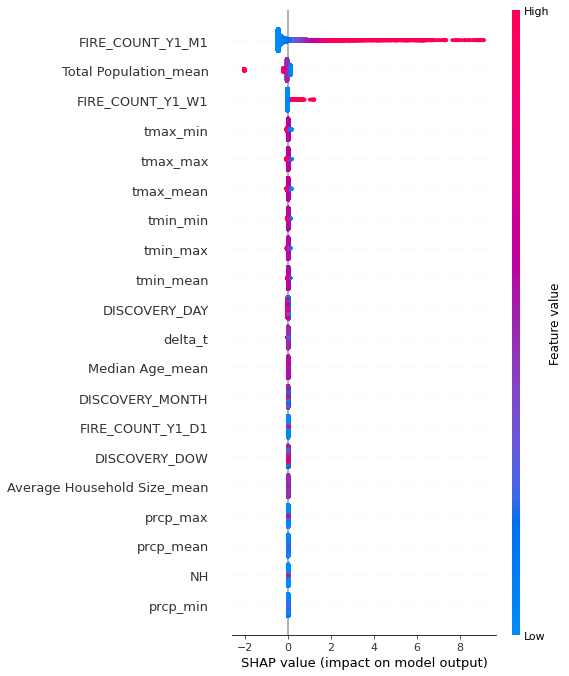

In [32]:
plot_shapley_values(logistic_regression)